In [2]:
#@title

import jax
import itertools
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
import pandas as pd
import ipywidgets as widgets

from jax.numpy.linalg import inv, pinv
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain
from functools import partial

from tqdm import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

2023-06-29 14:28:52.855600: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Stochastic Volatility Model

$$ x_0 \sim \mathcal{N}(0, \frac{\sigma_x^2}{1-\phi^2}) $$
$$ x_{t+1} = \mu(1-\phi)+\phi x_t + \sigma_x \eta_t $$
$$ y_t = \epsilon_t \exp(x_t/2) $$
$$ \eta_t, \epsilon_t \sim \mathcal{N}(0,1) $$
$$ \theta = (\mu, \phi, \sigma_x) $$

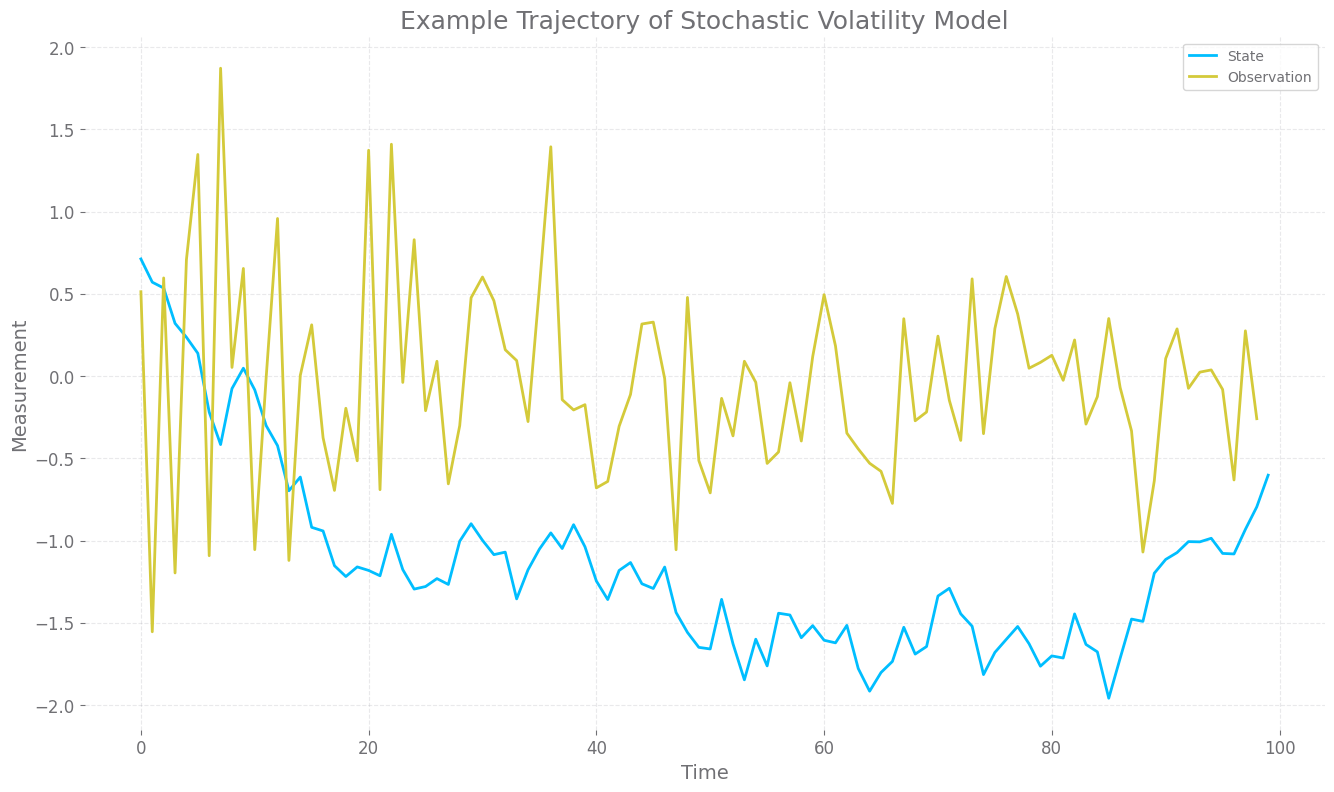

In [40]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def logit(x):
    return np.log(x/(1-x))

def get_thetas(theta):
    mu = theta[0]
    phi = sigmoid(theta[1])
    sigma = np.exp(theta[2])
    return mu, phi, sigma

def transform_thetas(mu, phi, sigma):
    return np.array([mu, logit(phi), np.log(sigma)])


theta = transform_thetas(2,0.9,1)
theta = transform_thetas(-1.23,0.9,0.16)

def get_traj():
    xs = []
    ys = []
    T = 100
    mu, phi, sigma = get_thetas(theta)
    x = np.sqrt(sigma**2/(1-phi**2)) * onp.random.normal()
    xs.append(x)
    for i in range(1,T):
        x = mu*(1-phi) + phi*x + sigma*onp.random.normal()
        eps = onp.random.normal()
        y = eps * np.exp(x/2)
        xs.append(x)
        ys.append(y)
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

xs, ys = get_traj()
plt.figure(figsize=(16,9))
plt.plot(xs, label='State')
plt.plot(ys, label='Observation')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()
plt.title('Example Trajectory of Stochastic Volatility Model')

plt.savefig('sv/trajs_sv.png')

In [3]:
def rinit(theta, J):
    mu, phi, sigma = get_thetas(theta)
    noise = np.array(onp.random.normal(size=J))
    return (np.sqrt(sigma**2/(1-phi**2)) 
            * noise)

def rprocess(x, theta):
    mu, phi, sigma = get_thetas(theta)
    noise = np.array(onp.random.normal(size=x.shape))
    return (mu*(1-phi) 
            + phi*x 
            + sigma*noise)

def dmeasure(y, preds, theta):
    return jax.scipy.stats.norm.logpdf(
                y, scale=np.exp(preds/2.))



rprocess = jax.jit(rprocess) 
dmeasure = jax.jit(dmeasure) #jax.jit(jax.vmap(dmeasure, in_axes=(None,0,None)))
loss_grad = (jax.vmap(jax.grad(dmeasure, argnums=1), in_axes=(None,0,None)))
rinits = jax.vmap(rinit, (0,None))
rprocesses = jax.vmap(rprocess, (0,0)) 
#dmeasures = jax.vmap(dmeasure, (None, None, 0))
dmeasures = jax.vmap(dmeasure, (None,0,0))


        mw = np.max(weights)
        reward = mw + np.log(np.mean(np.exp(weights - mw))) # p(y_t | x_{t,1:J}, \theta)
        rewards.append(reward)
        
        if reinforce:
            log_probs = weights#[counts]
            # log_probs is shape (Np,), contains (\log p(y_t | x_{t,j}^F, \theta))_j
            baseline = np.exp(reward)
            obj += np.mean(log_probs) * np.exp(reward) #take reward to be loglik over all particles
            #obj += np.mean(log_probs * (np.exp(log_probs))) #elementwise sum reward for each particle

In [4]:


-pfilter(theta, ys, J=10)

Array(-230.24121, dtype=float32)

In [5]:
theta_ests = transform_thetas(4,0.5,1.5) # also randomize starting values, one for each trajectory

In [379]:
newtif_logliks, newtif_params = newtif(theta_ests, ys, sigmas=np.array([0.001,0.0005,0.0005]), 
                                       sigmas_init = np.array([0.5,0.25,0.25]),
                                       M=10, J=100, a=0.8, beta=0.9, tau=10, monitor=True, thresh=0)
mif_logliks, mif_params = mif(theta_ests, ys, sigmas = np.array([0.001,0.0005,0.0005]), 
                              sigmas_init = np.array([0.5,0.25,0.25]),
                              M=10, J=100, a=0.8, monitor=True, thresh=0)
gd_logliks, gd_ests = train(theta_ests, ys, itns=10, J=100, thresh=0, newt=False)
newt_logliks, newt_ests = train(theta_ests, ys, itns=10, J=100, thresh=0, newt=True)

100%|██████████| 10/10 [00:41<00:00,  4.19s/it]


In [ ]:
n_trials = 100
trajs = [get_traj()[1] for i in range(n_trials)]
newtif_loglik_trials = [newtif(theta_ests, trajs[i], sigmas=np.array([0.001,0.0005,0.0005]), 
                                       sigmas_init = np.array([0.5,0.25,0.25]),
                                       M=20, J=100, a=0.8, beta=0.9, tau=10, 
                               monitor=True, thresh=0)[0] for i in range(n_trials)]
mif_loglik_trials = [mif(theta_ests, trajs[i], sigmas = np.array([0.001,0.0005,0.0005]), 
                              sigmas_init = np.array([0.5,0.25,0.25]),
                              M=20, J=100, a=0.8, monitor=True, thresh=0)[0] for i in range(n_trials)]
gd_loglik_trials = [train(theta_ests, trajs[i], newt=False, J=100, thresh=0)[0] for i in range(n_trials)]
newt_loglik_trials = [train(theta_ests, trajs[i], newt=True, J=100, thresh=0)[0] for i in range(n_trials)]

 45%|████▌     | 9/20 [00:53<01:07,  6.14s/it]

In [ ]:
ci = True

plt.figure(figsize=(16,9))
trials = [newt_loglik_trials, gd_loglik_trials, newtif_loglik_trials, mif_loglik_trials]
pd.DataFrame([np.array(trial).mean(0) for trial in trials], 
             index=['Newton', 'Gradient', 'Newton IF2', 'IF2']).T.astype(float).plot(figsize=(16,9))
if ci:
    for trial in trials:
        trial_df = pd.DataFrame(np.array(trial))
        plt.fill_between(np.arange(trial_df.shape[1]), 
                     trial_df.quantile(0.5, axis=0),
                     trial_df.quantile(0.5, axis=0),
                    alpha=0.3)
        
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('Iteration')
plt.legend()
plt.title('Performance of Various Methods on Stochastic Volatility')
plt.savefig('sv/optim_methods_avg.png')

Text(0.5, 1.0, 'Performance of Various Methods on Stochastic Volatility')

<Figure size 1600x900 with 0 Axes>

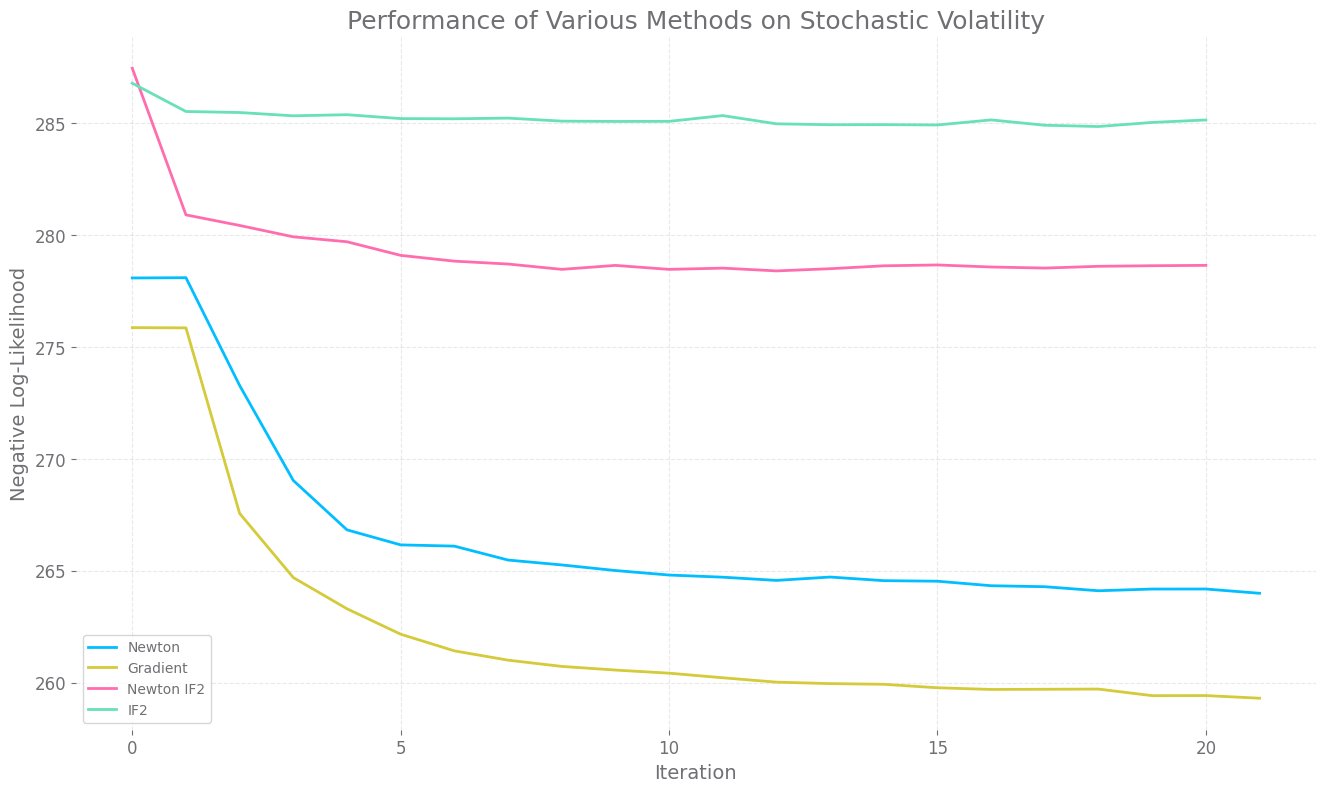

In [40]:
ci = True

plt.figure(figsize=(16,9))
trials = [newt_loglik_trials, gd_loglik_trials, newtif_loglik_trials, mif_loglik_trials]
pd.DataFrame([np.array(trial).mean(0) for trial in trials], 
             index=['Newton', 'Gradient', 'Newton IF2', 'IF2']).T.astype(float).plot(figsize=(16,9))
if ci:
    for trial in trials:
        trial_df = pd.DataFrame(np.array(trial))
        plt.fill_between(np.arange(trial_df.shape[1]), 
                     trial_df.quantile(0.5, axis=0),
                     trial_df.quantile(0.5, axis=0),
                    alpha=0.3)
        
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('Iteration')
plt.legend()
plt.title('Performance of Various Methods on Stochastic Volatility')
#plt.savefig('sv/optim_methods_avg.png')

Text(0.5, 1.0, 'Performance of Various Methods on Stochastic Volatility')

<Figure size 1600x900 with 0 Axes>

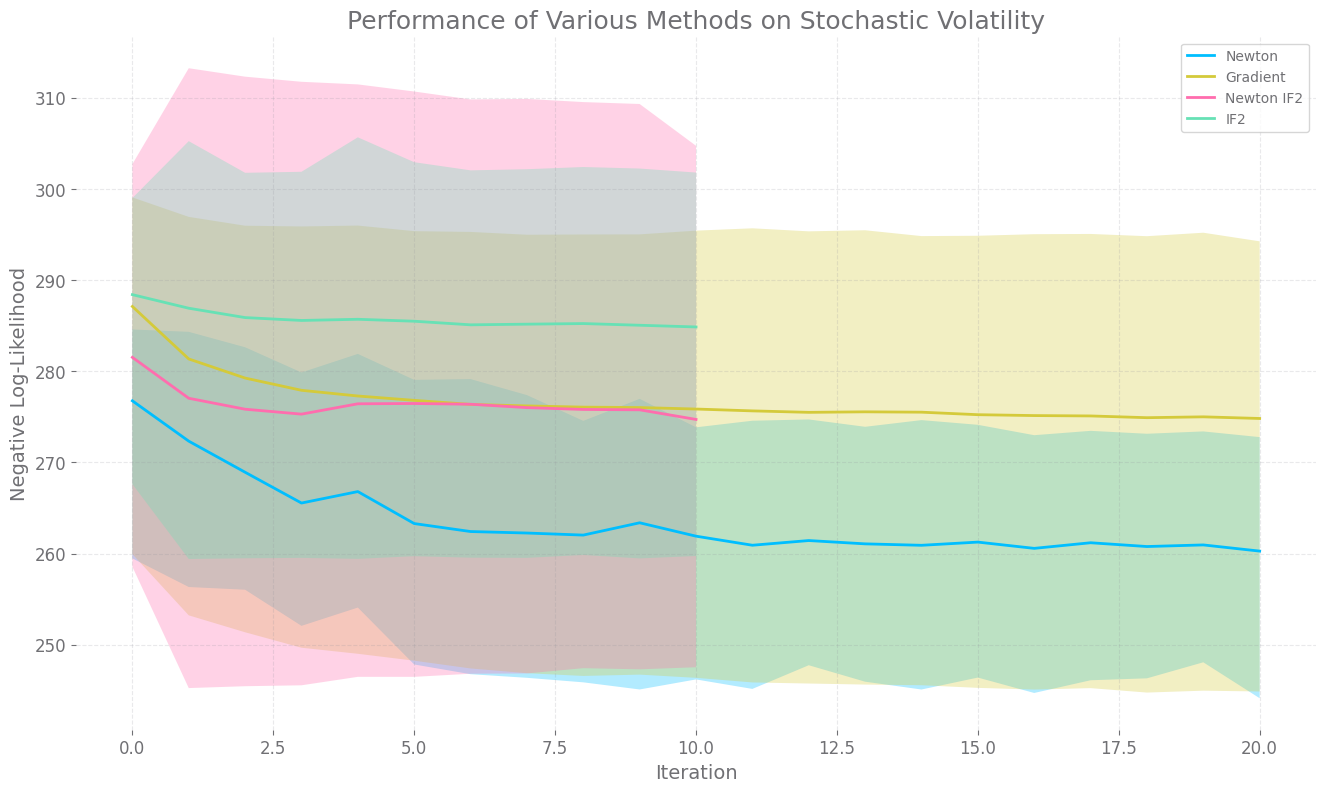

In [28]:
ci = True

plt.figure(figsize=(16,9))
trials = [newt_loglik_trials, gd_loglik_trials, newtif_loglik_trials, mif_loglik_trials]
pd.DataFrame([np.array(trial).mean(0) for trial in trials], 
             index=['Newton', 'Gradient', 'Newton IF2', 'IF2']).T.astype(float).plot(figsize=(16,9))
if ci:
    for trial in trials:
        trial_df = pd.DataFrame(np.array(trial))
        plt.fill_between(np.arange(trial_df.shape[1]), 
                     trial_df.mean(0)+(trial_df-trial_df.mean(0)).quantile(0.66, axis=0),
                     trial_df.mean(0)+(trial_df-trial_df.mean(0)).quantile(0.33, axis=0),
                    alpha=0.3)
        
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('Iteration')
plt.legend()
plt.title('Performance of Various Methods on Stochastic Volatility')
#plt.savefig('sv/optim_methods_avg.png')

<Figure size 1600x900 with 0 Axes>

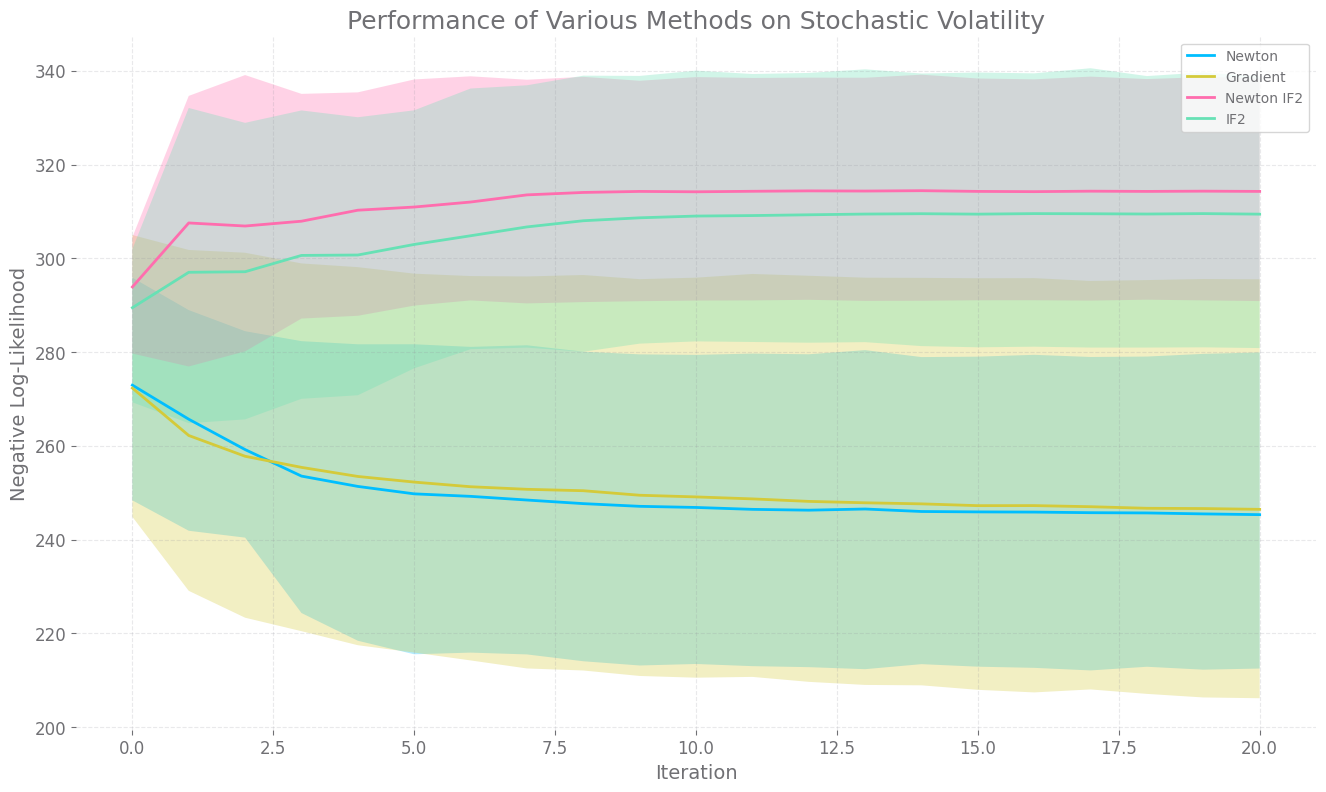

In [33]:
ci = True

plt.figure(figsize=(16,9))
trials = [newt_loglik_trials, gd_loglik_trials, newtif_loglik_trials, mif_loglik_trials]
pd.DataFrame([np.array(trial).mean(0) for trial in trials], 
             index=['Newton', 'Gradient', 'Newton IF2', 'IF2']).T.astype(float).plot(figsize=(16,9))
if ci:
    for trial in trials:
        trial_df = pd.DataFrame(np.array(trial))
        plt.fill_between(np.arange(trial_df.shape[1]), 
                     trial_df.quantile(0.25, axis=0),
                     trial_df.quantile(0.75, axis=0),
                    alpha=0.3)
        
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('Iteration')
plt.legend()
plt.title('Performance of Various Methods on Stochastic Volatility')
plt.savefig('sv/optim_methods_avg.png')

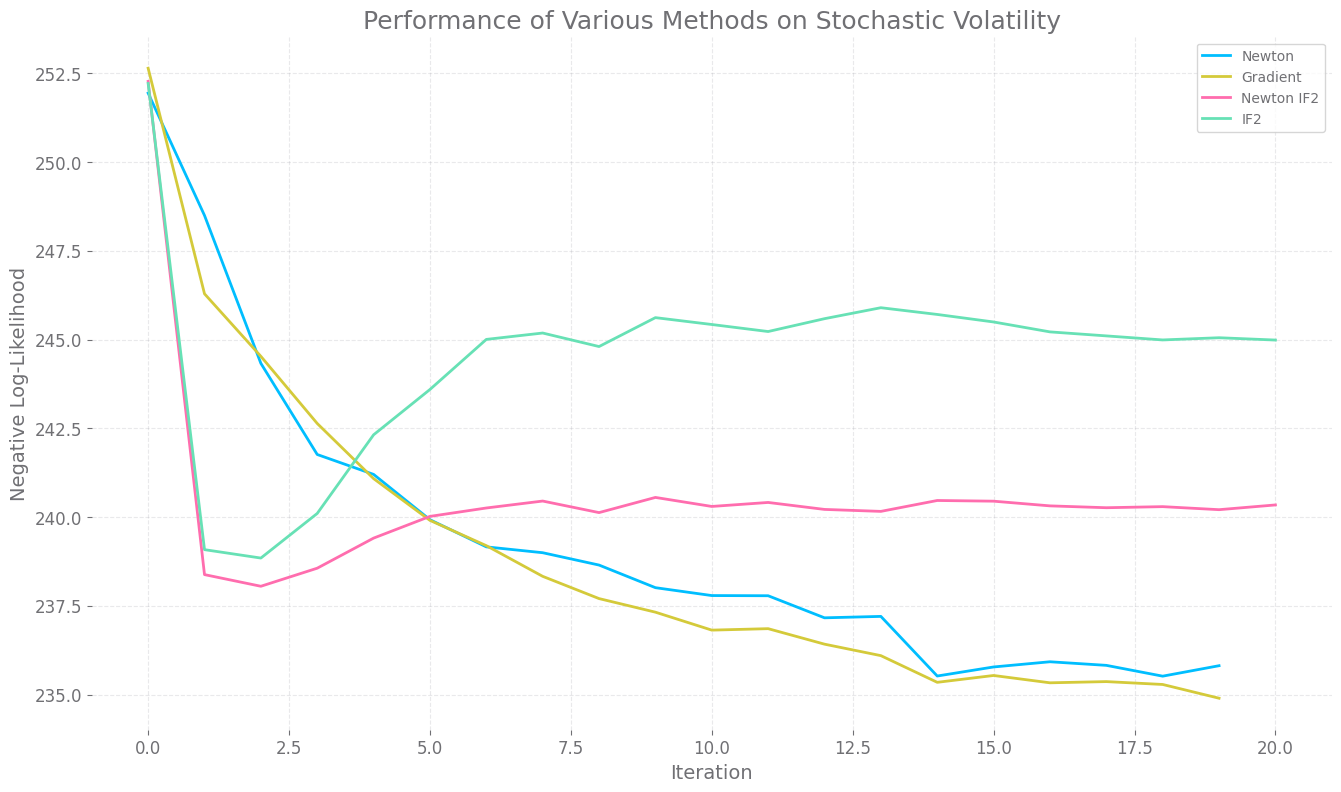

In [48]:
plt.figure(figsize=(16,9))
plt.plot(np.mean(np.array(newt_loglik_trials),0), label='Newton')
plt.plot(np.mean(np.array(gd_loglik_trials),0), label='Gradient')
plt.plot(np.mean(np.array(newtif_loglik_trials),0), label='Newton IF2')
plt.plot(np.mean(np.array(mif_loglik_trials),0), label='IF2')
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('Iteration')
plt.legend()
plt.title('Performance of Various Methods on Stochastic Volatility')
plt.savefig('sv/optim_methods_avg.png')

Text(0.5, 1.0, 'Performance of Various Methods on Stochastic Volatility')

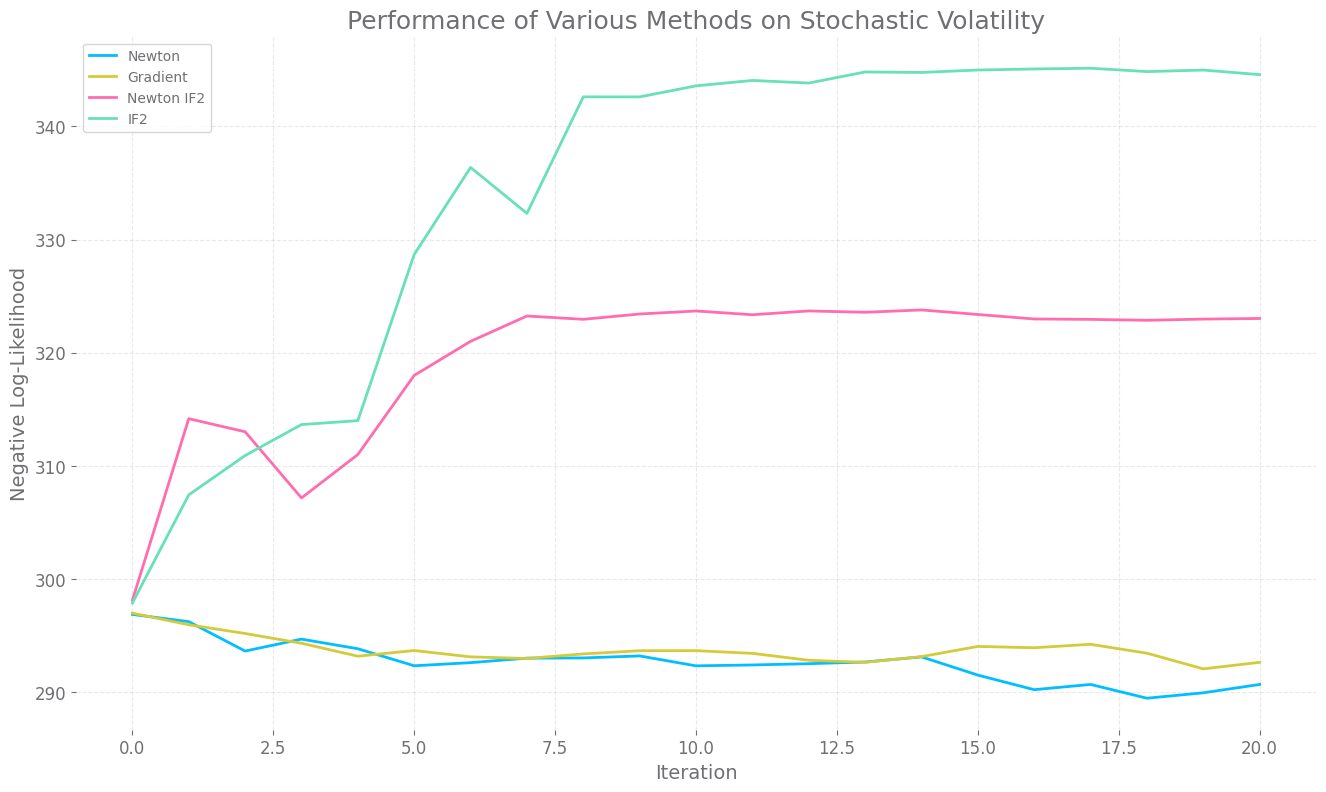

In [19]:
plt.figure(figsize=(16,9))
plt.plot(newt_logliks, label='Newton')
plt.plot(gd_logliks, label='Gradient')
plt.plot(newtif_logliks, label='Newton IF2')
plt.plot(mif_logliks, label='IF2')
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('Iteration')
plt.legend()
plt.title('Performance of Various Methods on Stochastic Volatility')

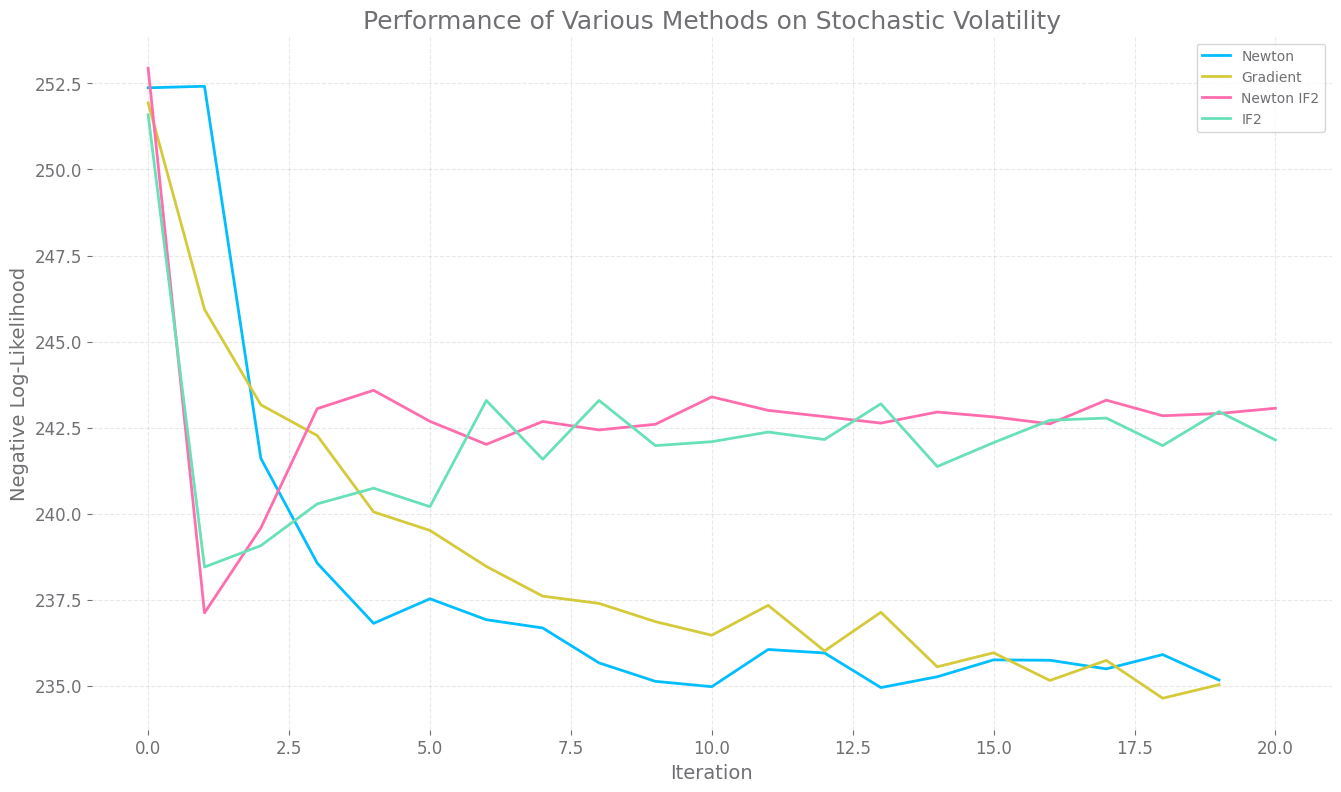

In [34]:
plt.figure(figsize=(16,9))
plt.plot(newt_logliks, label='Newton')
plt.plot(gd_logliks, label='Gradient')
plt.plot(newtif_logliks, label='Newton IF2')
plt.plot(mif_logliks, label='IF2')
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('Iteration')
plt.legend()
plt.title('Performance of Various Methods on Stochastic Volatility')
plt.savefig('sv/optim_sv_if2.png')

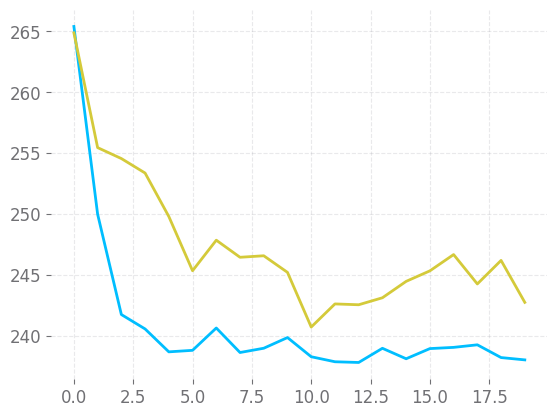

In [219]:
plt.plot(newt_logliks)
plt.plot(gd_logliks)

In [249]:
get_thetas(theta)

(Array(2., dtype=float32), Array(0.9, dtype=float32), Array(1., dtype=float32))

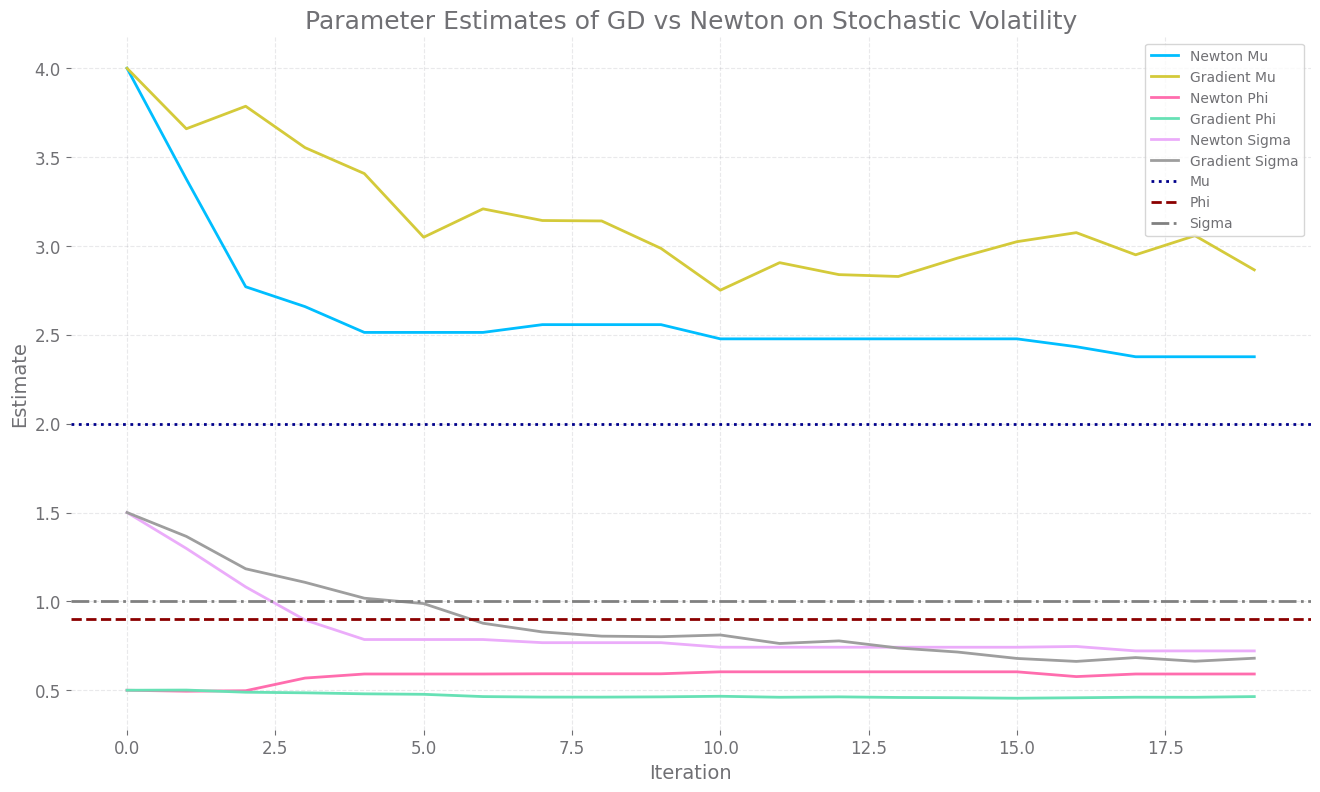

In [277]:
plt.figure(figsize=(16,9))

# Look at parameter estimates for the others

plt.plot(np.abs(np.exp(newt_ests[:,0])), label='Newton Mu')
plt.plot(np.abs(np.exp(gd_ests[:,0])), label='Gradient Mu')
plt.plot(np.abs(sigmoid(newt_ests[:,1])), label='Newton Phi')
plt.plot(np.abs(sigmoid(gd_ests[:,1])), label='Gradient Phi')
plt.plot(np.abs(np.exp(newt_ests[:,2])), label='Newton Sigma')
plt.plot(np.abs(np.exp(gd_ests[:,2])), label='Gradient Sigma')
plt.axhline(2, color='darkblue', linestyle='dotted', label='Mu')
plt.axhline(0.9, color='darkred', linestyle='dashed', label='Phi')
plt.axhline(1, color='grey', linestyle='dashdot', label='Sigma')
plt.xlabel('Iteration')
plt.ylabel('Estimate')

plt.title('Parameter Estimates of GD vs Newton on Stochastic Volatility')
plt.legend(loc='upper right')
plt.savefig('sv/params_sv.png')

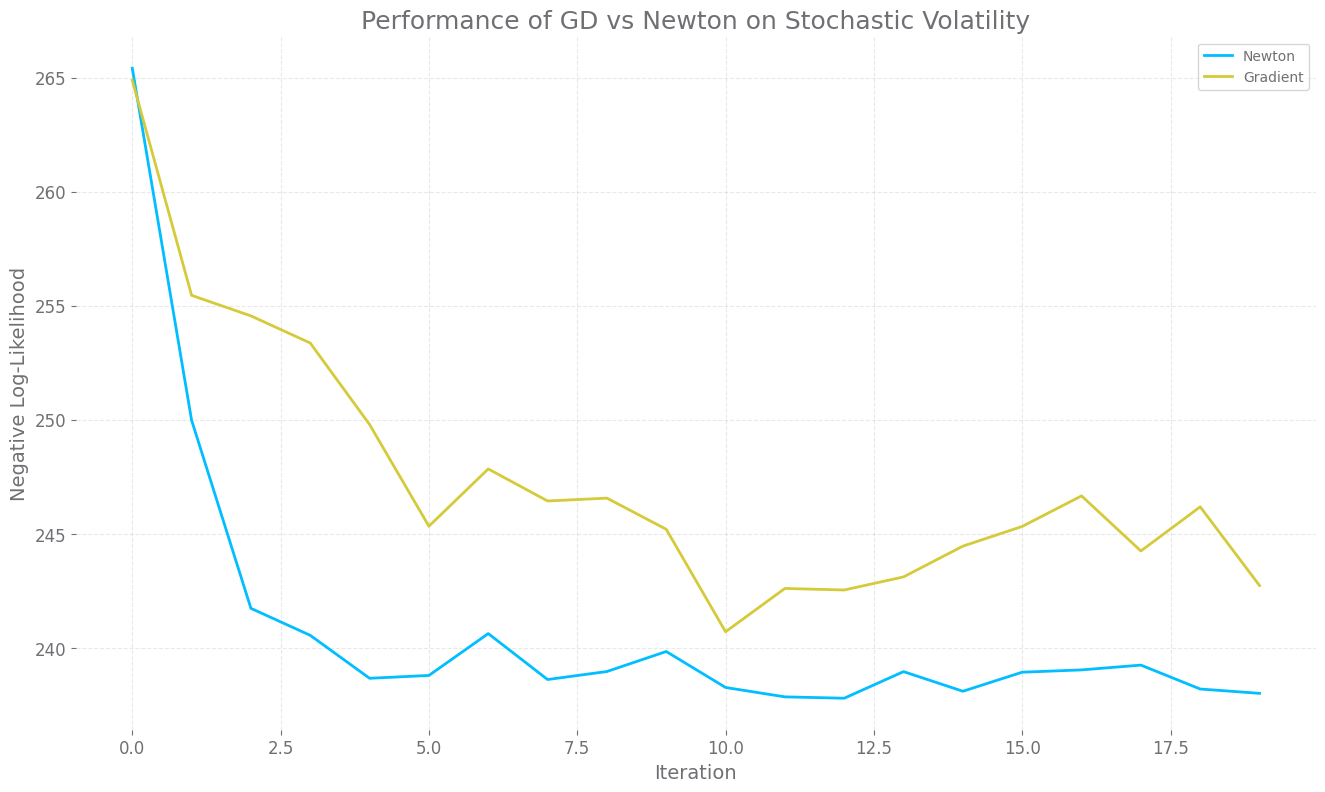

In [221]:
plt.figure(figsize=(16,9))
plt.plot(newt_logliks, label='Newton')
plt.plot(gd_logliks, label='Gradient')
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('Iteration')
plt.legend()
plt.title('Performance of GD vs Newton on Stochastic Volatility')
plt.savefig('sv/optim_sv.png')

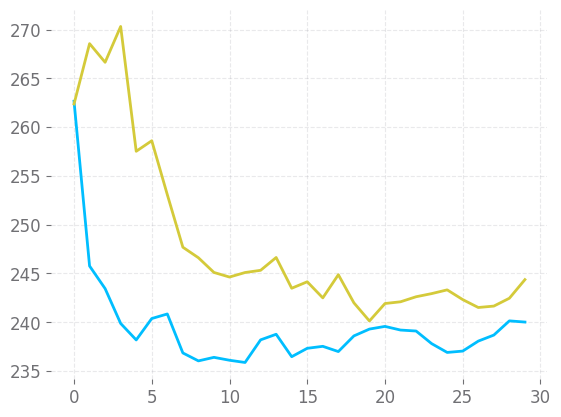

In [217]:
plt.plot(newt_logliks)
plt.plot(gd_logliks)

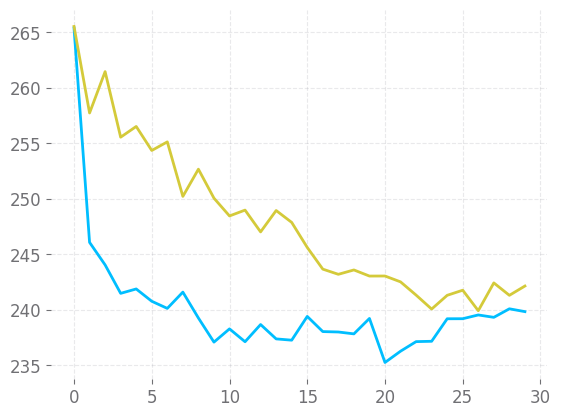

In [215]:
plt.plot(newt_logliks)
plt.plot(gd_logliks)

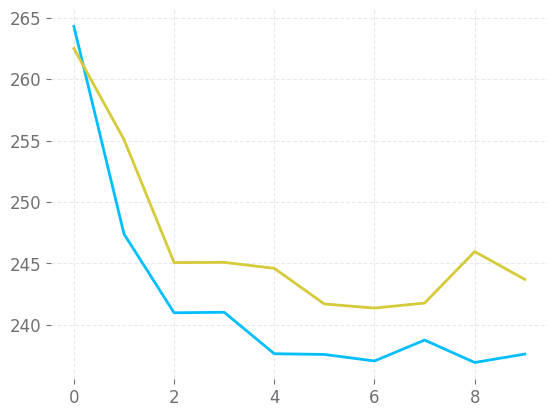

In [208]:
plt.plot(newt_logliks)
plt.plot(gd_logliks)